<a href="https://colab.research.google.com/github/MilianAlba/DMML2_CA/blob/main/DMML2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from re import sub
import tensorflow as tf
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

print("Done importing packages!")

Done importing packages!


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [3]:
#data_dir = "../input/plantvillage-dataset/color"
data_dir = "plantville"
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.28,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.08,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 20105 files belonging to 13 classes.
Using 14476 files for training.
Found 20105 files belonging to 13 classes.
Using 1608 files for validation.
Found 20105 files belonging to 13 classes.
Using 4021 files for validation.


In [4]:
class_names = train_dataset.class_names
num_classes = len(class_names)
for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Cedar_apple_rust
3.  Apple___healthy
4.  Pepper__bell___Bacterial_spot
5.  Pepper__bell___healthy
6.  Tomato___Bacterial_spot
7.  Tomato___Early_blight
8.  Tomato___Late_blight
9.  Tomato___Leaf_Mold
10.  Tomato___Septoria_leaf_spot
11.  Tomato___Tomato_Yellow_Leaf_Curl_Virus
12.  Tomato___Tomato_mosaic_virus
13.  Tomato___healthy


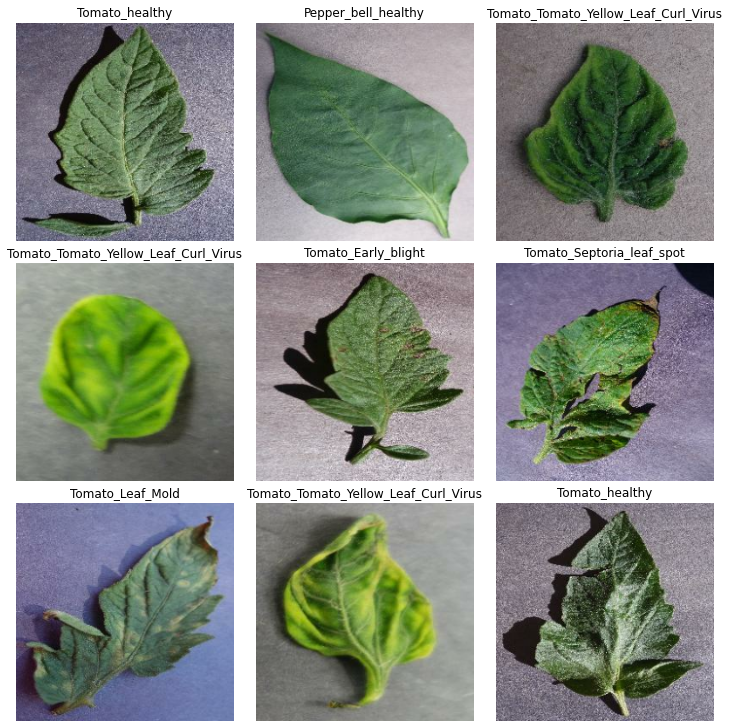

In [7]:
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

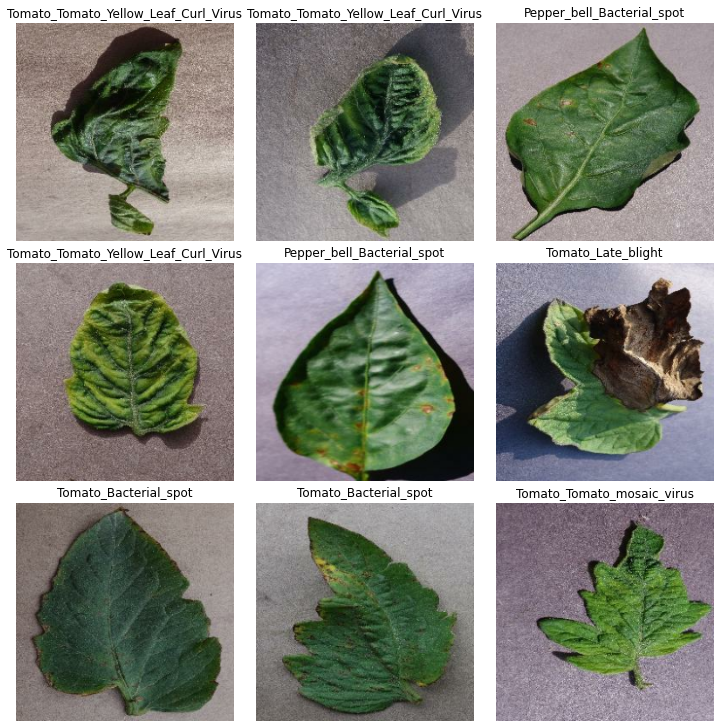

In [8]:
plt.figure(figsize=(10, 10), constrained_layout=True)
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = sub(r"[_]+","_",class_names[np.argmax(labels[i])])
        plt.title(title)
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 41
Number of test batches: 10


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
     
]

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [12]:
base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [17]:
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [20]:
len(model.trainable_variables)

2

In [21]:
initial_epochs = 10

In [22]:
len(train_dataset)

453

In [23]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
453/453 [==============================] - 48s 97ms/step - loss: 1.6531 - accuracy: 0.4864 - precision: 0.8815 - recall: 0.2276 - auc: 0.8682 - val_loss: 0.9890 - val_accuracy: 0.7523 - val_precision: 0.9821 - val_recall: 0.4270 - val_auc: 0.9743
Epoch 2/10
453/453 [==============================] - 42s 93ms/step - loss: 0.8443 - accuracy: 0.7655 - precision: 0.9423 - recall: 0.5457 - auc: 0.9769 - val_loss: 0.6377 - val_accuracy: 0.8432 - val_precision: 0.9698 - val_recall: 0.6483 - val_auc: 0.9904
Epoch 3/10
453/453 [==============================] - 42s 93ms/step - loss: 0.6095 - accuracy: 0.8313 - precision: 0.9389 - recall: 0.6825 - auc: 0.9887 - val_loss: 0.4963 - val_accuracy: 0.8859 - val_precision: 0.9696 - val_recall: 0.7422 - val_auc: 0.9942
Epoch 4/10
453/453 [==============================] - 42s 92ms/step - loss: 0.4966 - accuracy: 0.8586 - precision: 0.9422 - recall: 0.7541 - auc: 0.9924 - val_loss: 0.4104 - val_accuracy: 0.9045 - val_precision: 0.9615 - val_r

In [50]:
epochs = list(range (1,11))
history_df = pd.DataFrame(history.history)
history_df['epochs'] = epochs
history_df['stage'] = 'first_raining'
print(history_df)

       loss       tp     fp        tn       fn  accuracy  precision    recall  \
0  1.624914   3517.0  415.0  173297.0  10959.0  0.512158   0.894456  0.242954   
1  0.841269   8102.0  616.0  173096.0   6374.0  0.766579   0.929342  0.559685   
2  0.610600   9965.0  679.0  173033.0   4511.0  0.824813   0.936208  0.688381   
3  0.500169  10896.0  724.0  172988.0   3580.0  0.856245   0.937694  0.752694   
4  0.428815  11488.0  700.0  173012.0   2988.0  0.876831   0.942566  0.793589   
5  0.378738  11872.0  672.0  173040.0   2604.0  0.891406   0.946429  0.820116   
6  0.349867  12129.0  689.0  173023.0   2347.0  0.899282   0.946247  0.837870   
7  0.320770  12355.0  643.0  173069.0   2121.0  0.908055   0.950531  0.853482   
8  0.297872  12544.0  651.0  173061.0   1932.0  0.911992   0.950663  0.866538   
9  0.277387  12736.0  613.0  173099.0   1740.0  0.918071   0.954079  0.879801   

        auc  val_loss  val_tp  val_fp   val_tn  val_fn  val_accuracy  \
0  0.871087  0.974061   590.0    16.

Start fine tuning phase

In [24]:
base_model.trainable = True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [26]:
# Learning rate goes dowb by a factor of 10
fine_tuning_learning_rate = 1e-5
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tuning_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [28]:
len(model.trainable_variables)

56

In [31]:

fine_tune_epochs = 7
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/17
453/453 [==============================] - 63s 138ms/step - loss: 0.1894 - accuracy: 0.9371 - precision: 0.9517 - recall: 0.9244 - auc: 0.9976 - val_loss: 0.1284 - val_accuracy: 0.9612 - val_precision: 0.9675 - val_recall: 0.9488 - val_auc: 0.9989
Epoch 11/17
453/453 [==============================] - 61s 135ms/step - loss: 0.1167 - accuracy: 0.9618 - precision: 0.9673 - recall: 0.9552 - auc: 0.9990 - val_loss: 0.1196 - val_accuracy: 0.9620 - val_precision: 0.9655 - val_recall: 0.9557 - val_auc: 0.9983
Epoch 12/17
453/453 [==============================] - 61s 135ms/step - loss: 0.0789 - accuracy: 0.9727 - precision: 0.9781 - recall: 0.9690 - auc: 0.9995 - val_loss: 0.1095 - val_accuracy: 0.9651 - val_precision: 0.9694 - val_recall: 0.9596 - val_auc: 0.9987
Epoch 13/17
453/453 [==============================] - 61s 135ms/step - loss: 0.0591 - accuracy: 0.9813 - precision: 0.9844 - recall: 0.9784 - auc: 0.9997 - val_loss: 0.1140 - val_accuracy: 0.9612 - val_precision: 0.9618

In [63]:
epochst = list(range (11,22))
historyfinetune_df = pd.DataFrame(history_fine.history)
historyfinetune_df['epochs'] = epochst
historyfinetune_df['stage'] = 'fine_tune'
print(historyfinetune_df)

        loss       tp    fp        tn    fn  accuracy  precision    recall  \
0   0.023637  14377.0  78.0  173634.0  99.0  0.993990   0.994604  0.993161   
1   0.017402  14393.0  72.0  173640.0  83.0  0.994612   0.995022  0.994266   
2   0.013099  14424.0  45.0  173667.0  52.0  0.996684   0.996890  0.996408   
3   0.012068  14425.0  46.0  173666.0  51.0  0.996546   0.996821  0.996477   
4   0.007294  14457.0  17.0  173695.0  19.0  0.998757   0.998825  0.998688   
5   0.006586  14458.0  16.0  173696.0  18.0  0.998826   0.998895  0.998757   
6   0.008927  14442.0  27.0  173685.0  34.0  0.997859   0.998134  0.997651   
7   0.004669  14462.0  11.0  173701.0  14.0  0.999033   0.999240  0.999033   
8   0.006735  14446.0  25.0  173687.0  30.0  0.998135   0.998272  0.997928   
9   0.003621  14466.0   9.0  173703.0  10.0  0.999378   0.999378  0.999309   
10  0.005533  14455.0  20.0  173692.0  21.0  0.998549   0.998618  0.998549   

         auc  val_loss  val_tp  val_fp   val_tn  val_fn  val_ac

In [ ]:
ht_df = pd.concat([history_df, historyfinetune_df], axis=0, ignore_index=True)
print(ht_df)
ht_df.to_csv('resultsIndoorModel.csv')

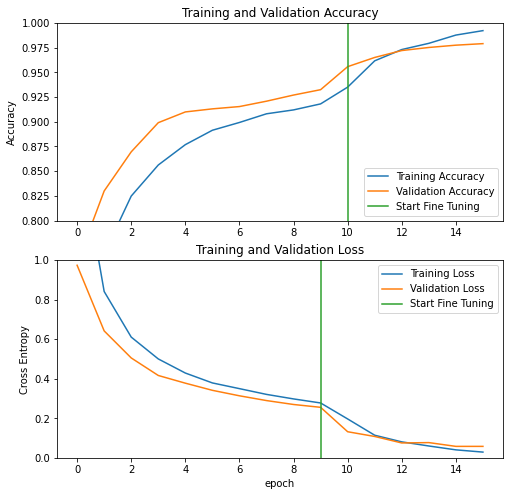

In [68]:
acc = ht_df['accuracy']
val_acc = ht_df['val_accuracy']

loss = ht_df['loss']
val_loss = ht_df['val_loss']
epochs = ht_df['epochs']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10,10],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

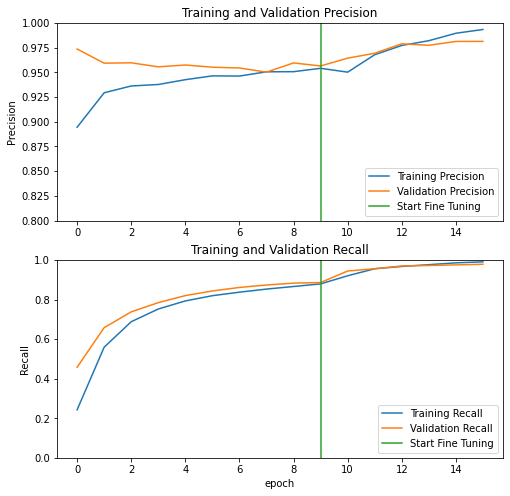

In [59]:
precision = ht_df['precision']
val_prec = ht_df['val_precision']

recall = ht_df['recall']
val_recall = ht_df['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_prec, label='Validation Precision')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.ylabel('Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.ylabel('Recall')
plt.show()

Model Creation for the right epochs.

In [39]:
result = model.evaluate(test_dataset)

10/10 [==============================] - 1s 85ms/step - loss: 0.0652 - accuracy: 0.9719 - precision: 0.9748 - recall: 0.9656 - auc: 0.9998


In [34]:
print(len(test_dataset))

10


In [35]:
print(len(validation_dataset))

41


In [36]:
print(len(train_dataset))

453


In [42]:
metrics = ["loss", "accuracy", "precision", "recall", "auc"]
for i in range(len(result)):
    print("{} : {}".format(metrics[i],round(result[i], 3)))

loss : 0.054
accuracy : 0.983
precision : 0.984
recall : 0.981
auc : 0.999


In [38]:
testOut_dataset = image_dataset_from_directory('testplantdoc',
                                             label_mode = 'categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 120 files belonging to 13 classes.


In [43]:
resultOut = model.evaluate(testOut_dataset)

4/4 [==============================] - 2s 198ms/step - loss: 9.7876 - accuracy: 0.0750 - precision: 0.0826 - recall: 0.0750 - auc: 0.5366


In [46]:
metrics = ["loss", "accuracy", "precision", "recall", "auc"]
for i in range(len(resultOut)):
    print("{} : {}".format(metrics[i],round(resultOut[i], 3)))

loss : 9.788
accuracy : 0.075
precision : 0.083
recall : 0.075
auc : 0.537


In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
models.save_model(model, "./HPMobileNetAdam_indoor")

In [43]:
models.save_model(model, "./HPMobileNetAdam_indoor")

INFO:tensorflow:Assets written to: ./HPMobileNetAdam_indoor/assets


INFO:tensorflow:Assets written to: ./HPMobileNetAdam_indoor/assets
